In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import NetDes
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

<b style="font-size:26px;">Step 1: Load data</b>

Pseudotime values are loaded from 'testdatatime.csv' into a dataframe containing one column.

A set of scRNA-seq gene expression data is read from 'testexpression.csv'. It is recommended to work on a dataset with more than 10,000 cells. 

The initial Gene Regulatory Network (GRN) is read from 'Initial_network.csv'.

In [2]:
pseudo=pd.read_csv("testdatatime.csv") # load pseudotime
tf12=pd.read_csv('testexpression.csv') # load smoothed data, this data should be processed by log transform
network1=pd.read_csv('Initial_network.csv')# load initial GRN
#net1_restrictions=pd.read_csv('network1_interlist.csv') # load the interactions forced to be in the GRN
names=tf12.iloc[:, 0] # obtain gene names
tf12.index = [names] #set rownames
cellnames = list(tf12.columns) 
cellnames2=cellnames[1:] #obtain cell names
pseudo['cellnames']=cellnames2 # assign the cell name pseudotime dataframe
gene_list = pd.unique(network1['Target'])# We begin by calculating the model for the genes that have a Source input
network1.columns = ['Source', 'Target', 'Interaction']

# Assigning pseudotime to pseudotime_col 
pseudotime, tf12pickcell,cellpick = NetDes.selectcell(pseudo, tf12,pseudotime_col=0)
tf12expression,tf12expression_logtarget, pseudotime_pick = NetDes.process_tf(tf12, tf12pickcell, pseudo, cellpick,pseudotime_col=0)

<b style="font-size:26px;">Step 2: First round of optimization</b>

For each gene \(i\) and its regulator \(j\), we sampled the initial $$\lambda_{ij}$$ from the following ranges:

$$2 < \lambda_{ij} < 4 \quad \text{(for activation)}$$

and 

$$0.25 < \lambda_{ij} < 0.5 \quad \text{(for inhibition)}$$

to ensure all activation/inhibition combinations from all regulators of gene \(i\).



By default, NetDes performs optimization for all sampled initial parameters. one can add argument 'pick=0.1' to perform optimization only for 10% of sampled initial parameters. 



In [3]:
random.seed(1)
#First stage
Part1=NetDes.MSE_stPoint(gene_list=gene_list,network=network1,
                  expression=tf12expression,log_expression=tf12expression_logtarget)


gene2
gene1
gene3


<b style="font-size:26px;">Step 3: Second round of optimization</b>

In the second round of optimization, the initial parameters are resampled based on the top-performing models from the first round of optimization.

In [4]:
Part2= NetDes.MSE_top(gene_list=gene_list,network=network1,
               expression=tf12expression,log_expression=tf12expression_logtarget,MSE_table=Part1)


gene2
gene1
gene3


<b style="font-size:26px;">Step 4: Optimization based on reduced regulatory scenarios</b>

For each reduced regulatroy scenario, a subset of regulators are removed for model fitting. From the optimization results, the best reduced regulatory scenarios are identified. 

In [5]:
w_tot=NetDes.tuning(MSE_table2=Part2,nums=20,gene_list=gene_list) # Optimize with tuning parameters
Part3=NetDes.MSE_bin(MSE_table2=Part2,w_tot=w_tot,gene_list=gene_list,
              network=network1,expression=tf12expression,log_expression=tf12expression_logtarget)# Identify removable edges
consis_results=NetDes.consis_test(gene_list=gene_list,MSE_table=Part3)
int_test=NetDes.interactions_test(gene_list=gene_list,network=network1,
                           consis=consis_results,MSE_table=Part3,expression=tf12expression,log_expression=tf12expression_logtarget,tolerance=[0.01,0.99])


gene2
gene1
gene3
gene2
gene1
gene3


<b style="font-size:26px;">Step 5: Optimization to refine and finalize the ODE model </b>

Newly fitted models and their corresponding regulatory scenarios were ranked by a reducibility index I, and we show a plot which display how the network size changes as we set cutoff value varies for I.

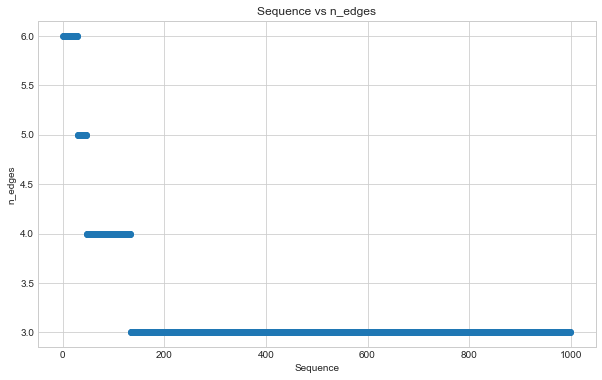

In [6]:
lines_MSEcut_df = NetDes.plot_sequence_vs_edges(gene_list=gene_list, network=network1,start=1, stop=1000, step=1, int_results=int_test, consis_res=consis_results, plot_type='scatter')

The following code block illustrates a way to set the cutoff parameter ('cut_value') according to the desired total number of network edges. Another way is to simply select 'cut_value =30'.

In [7]:
# cut_value = lines_MSEcut_df[lines_MSEcut_df['n_edges'] == 5]['Sequence']

The model parameters are stored in 'res_final', and the network topology is saved in 'combined_network'.

In [8]:
cut_value =30
del_results=NetDes.delete_int(gene_list=gene_list,network=network1,int_results=int_test,consis_res=consis_results,MSE_cut=cut_value)
Part4=NetDes.MSE_delete_fitting(gene_list=gene_list,network=network1,expression=tf12expression,log_expression=tf12expression_logtarget,del_int=del_results)
w_tot_2=NetDes.tuning(MSE_table2=Part4,nums=20,gene_list=gene_list)
res_final=NetDes.parameter_fitting(MSE_del_table=Part4,w_tot=w_tot_2,gene_list=gene_list,del_int=del_results,network=network1,expression=tf12expression,log_expression=tf12expression_logtarget)
ob_newall=Part4[1].copy()
res_final=res_final[0]
combined_network = NetDes.save_combined_network(gene_list, ob_newall, res_final,output="test.csv")


gene2
gene1
gene3
gene2
['gene1', 'gene4']
gene1
['gene2', 'gene3']
gene3
['gene2']


Visualize the fitting results

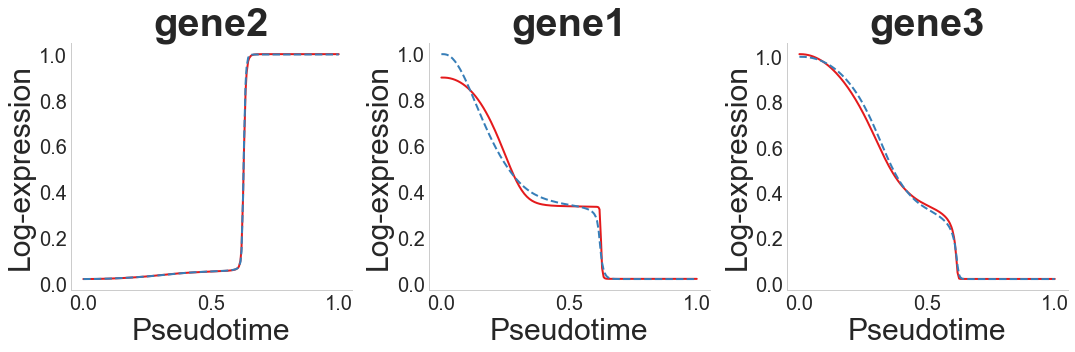

In [9]:
NetDes.plot_network_results(
    gene_list=gene_list,
    network=network1,
    tfexpression=tf12expression,
    ob_newall=ob_newall,
    res_final=res_final,
    tfexpression_logtarget=tf12expression_logtarget,
    pseudotime_pick=pseudotime_pick
)

plt.savefig('fitting1.pdf', format='pdf', bbox_inches='tight')

<b style="font-size:26px;">Step 6: Simulation of network gene expression dynamics</b>

First, a combined GRN dynamical model is established.

In [10]:
tf12expression_logtarget2, tf12expression_target2, gene_position,gene_list2 = NetDes.process_gene_expression(tf12expression_logtarget, 
                                                                           tf12expression, 
                                                                           gene_list, 
                                                                           ob_newall)

ob_newall2, res_final2,gene_position2=NetDes.Fit_withoutinput(gene_list=gene_list2,
                                                              res_final=res_final,ob_newall=ob_newall,gene_position=gene_position,tfexpression_logtarget=tf12expression_logtarget)

gene4


Gene expression dynamics is simulated by driving the GRN with the trajectory of one network gene.

'df' shows the differences in gene expression between the observed trajectories and the simulated trajectories with forward signaling. 'df_dif' shows the differences in gene expression between the simulated trajectories with forward signaling and the simulated trajectroies wiht backward signaling.

In [11]:
drivers = pd.unique(combined_network['Source']) 
df, df_dif =NetDes.one_gene_driving(dt=0.1,t_tot=500,gene_list= gene_list2, drivers=drivers,
                             tfexpression_target2=tf12expression_target2,res_final=res_final2,
                              gene_position=gene_position2,network=network1, 
                              tfexpression=tf12expression, ob_all=ob_newall2)

gene2
gene1
gene3
gene4


Gene expression dynamics is simulated by driving the GRN with the trajectories of two network genes.

'df_2lines' shows the differences in gene expression between the observed trajectories and the simulated trajectories with forward signaling. 'df_2lines_dif' shows the differences in gene expression between the simulated trajectories with forward signaling and the simulated trajectroies wiht backward signaling.

In [12]:
df_2lines, df_2lines_dif=NetDes.two_gene_driving(dt=1,t_tot=5000,gene_list=gene_list2,drivers=drivers,tfexpression_target2=tf12expression_target2,res_final=res_final2,gene_position=gene_position2,
                 tfexpression=tf12expression,ob_all=ob_newall2,network=network1)

gene2
gene1
0.00
gene2
gene3
0.17
gene2
gene4
0.33
gene1
gene3
0.50
gene1
gene4
0.67
gene3
gene4
0.83


Drivability of the system can be examined for genes specified in 'dri_genes'.

Drive with one gene

Processing single gene: gene4


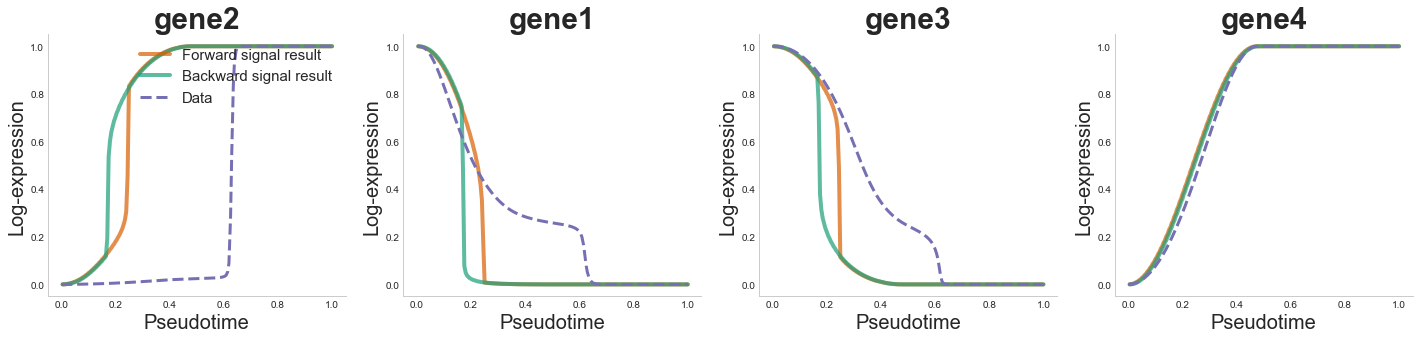

In [13]:

cache={}
df3, df4,cache,figs = NetDes.driving_results(
    dri_genes=["gene4"],
    gene_list=gene_list2,
    tfexpression_target2=tf12expression_target2,
    network=network1,
    tfexpression=tf12expression,
    pseudotime_pick=pseudotime_pick,
    res_final=res_final2,
    ob_newall=ob_newall2,
    gene_position=gene_position2,
    cached=False,
    cache=cache# Enable caching for faster subsequent runs
)

figs.savefig('driving_results_figure_6inGRN_gene4.pdf', dpi=300, bbox_inches='tight')

Drive with two genes

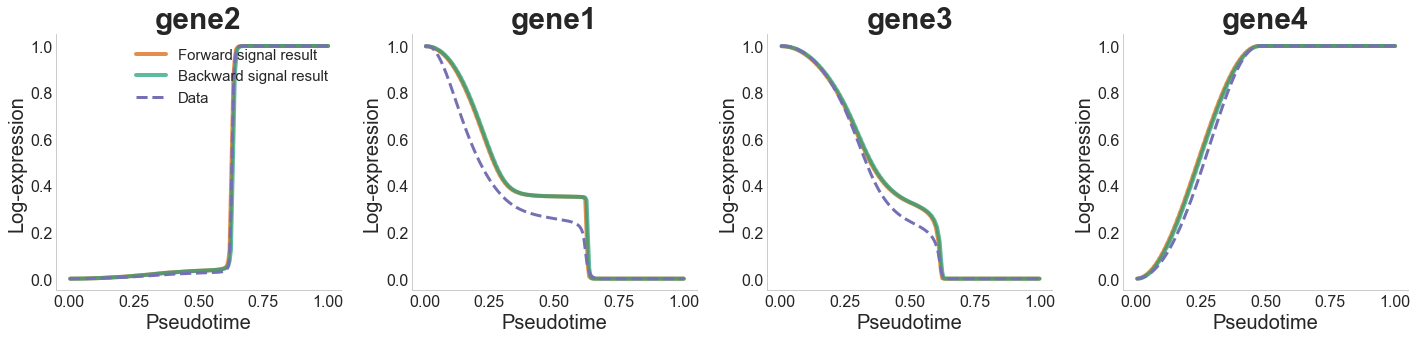

In [14]:
df3, df4,cache,figs = NetDes.driving_results(
    dri_genes=["gene4","gene2"],
    gene_list=gene_list2,
    tfexpression_target2=tf12expression_target2,
    network=network1,
    tfexpression=tf12expression,
    pseudotime_pick=pseudotime_pick,
    res_final=res_final2,
    ob_newall=ob_newall2,
    gene_position=gene_position2,
    cached=False,
    cache=cache# Enable caching for faster subsequent runs
)

figs.savefig('driving_results_figure_6inGRN_gene4_gene2.pdf', dpi=300, bbox_inches='tight')